In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Lambda(lambda x: x * 2. - 1.)  # [-1, 1]
])
dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [3]:
T = 1000  # steps
beta = torch.linspace(1e-4, 0.02, T)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def noise_schedule(t):
    return alpha_bar[t]

def q_sample(x0, t, noise):
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise


In [4]:
class SimpleDiffusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1),
        )

    def forward(self, x, t):
        # Optional: embed t into the model for time conditioning
        return self.net(x)


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleDiffusionNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def q_sample(x0, t, noise):
    ab = alpha_bar.to(x0.device)[t]  # move to correct device
    sqrt_ab = torch.sqrt(ab)[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - ab)[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise
    
for epoch in range(100):
    for x0, _ in tqdm(dataloader):
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)

        xt = q_sample(x0, t, noise)
        pred_noise = model(xt, t)

        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")


100%|██████████| 469/469 [00:06<00:00, 70.69it/s]


Epoch 1: loss = 0.0713


100%|██████████| 469/469 [00:06<00:00, 71.01it/s]


Epoch 2: loss = 0.0963


100%|██████████| 469/469 [00:06<00:00, 70.11it/s]


Epoch 3: loss = 0.0630


100%|██████████| 469/469 [00:06<00:00, 69.09it/s]


Epoch 4: loss = 0.0672


100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch 5: loss = 0.0691


100%|██████████| 469/469 [00:06<00:00, 71.02it/s]


Epoch 6: loss = 0.0690


100%|██████████| 469/469 [00:06<00:00, 68.99it/s]


Epoch 7: loss = 0.0632


100%|██████████| 469/469 [00:06<00:00, 69.14it/s]


Epoch 8: loss = 0.0568


100%|██████████| 469/469 [00:06<00:00, 71.05it/s]


Epoch 9: loss = 0.0598


100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch 10: loss = 0.0610


100%|██████████| 469/469 [00:06<00:00, 71.11it/s]


Epoch 11: loss = 0.0538


100%|██████████| 469/469 [00:06<00:00, 70.16it/s]


Epoch 12: loss = 0.0570


100%|██████████| 469/469 [00:06<00:00, 70.02it/s]


Epoch 13: loss = 0.0537


100%|██████████| 469/469 [00:06<00:00, 69.84it/s]


Epoch 14: loss = 0.0513


100%|██████████| 469/469 [00:06<00:00, 68.11it/s]


Epoch 15: loss = 0.0550


100%|██████████| 469/469 [00:06<00:00, 70.04it/s]


Epoch 16: loss = 0.0437


100%|██████████| 469/469 [00:06<00:00, 70.10it/s]


Epoch 17: loss = 0.0520


100%|██████████| 469/469 [00:06<00:00, 69.08it/s]


Epoch 18: loss = 0.0580


100%|██████████| 469/469 [00:06<00:00, 71.09it/s]


Epoch 19: loss = 0.0601


100%|██████████| 469/469 [00:06<00:00, 71.01it/s]


Epoch 20: loss = 0.0456


100%|██████████| 469/469 [00:06<00:00, 71.06it/s]


Epoch 21: loss = 0.0492


100%|██████████| 469/469 [00:06<00:00, 70.02it/s]


Epoch 22: loss = 0.0602


100%|██████████| 469/469 [00:06<00:00, 71.09it/s]


Epoch 23: loss = 0.0580


100%|██████████| 469/469 [00:06<00:00, 71.10it/s]


Epoch 24: loss = 0.0577


100%|██████████| 469/469 [00:06<00:00, 70.00it/s]


Epoch 25: loss = 0.0593


100%|██████████| 469/469 [00:06<00:00, 70.14it/s]


Epoch 26: loss = 0.0564


100%|██████████| 469/469 [00:06<00:00, 71.16it/s]


Epoch 27: loss = 0.0547


100%|██████████| 469/469 [00:06<00:00, 68.92it/s]


Epoch 28: loss = 0.0531


100%|██████████| 469/469 [00:06<00:00, 71.09it/s]


Epoch 29: loss = 0.0547


100%|██████████| 469/469 [00:07<00:00, 66.16it/s]


Epoch 30: loss = 0.0552


100%|██████████| 469/469 [00:06<00:00, 72.13it/s]


Epoch 31: loss = 0.0588


100%|██████████| 469/469 [00:09<00:00, 51.59it/s]


Epoch 32: loss = 0.0547


100%|██████████| 469/469 [00:06<00:00, 67.05it/s]


Epoch 33: loss = 0.0471


100%|██████████| 469/469 [00:06<00:00, 70.10it/s]


Epoch 34: loss = 0.0564


100%|██████████| 469/469 [00:06<00:00, 70.04it/s]


Epoch 35: loss = 0.0499


100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch 36: loss = 0.0517


100%|██████████| 469/469 [00:06<00:00, 71.09it/s]


Epoch 37: loss = 0.0460


100%|██████████| 469/469 [00:06<00:00, 71.05it/s]


Epoch 38: loss = 0.0469


100%|██████████| 469/469 [00:07<00:00, 66.13it/s]


Epoch 39: loss = 0.0573


100%|██████████| 469/469 [00:06<00:00, 70.13it/s]


Epoch 40: loss = 0.0499


100%|██████████| 469/469 [00:06<00:00, 71.11it/s]


Epoch 41: loss = 0.0531


100%|██████████| 469/469 [00:06<00:00, 70.00it/s]


Epoch 42: loss = 0.0475


100%|██████████| 469/469 [00:07<00:00, 66.11it/s]


Epoch 43: loss = 0.0538


100%|██████████| 469/469 [00:06<00:00, 70.13it/s]


Epoch 44: loss = 0.0522


100%|██████████| 469/469 [00:06<00:00, 69.94it/s]


Epoch 45: loss = 0.0584


100%|██████████| 469/469 [00:06<00:00, 71.13it/s]


Epoch 46: loss = 0.0498


100%|██████████| 469/469 [00:06<00:00, 71.13it/s]


Epoch 47: loss = 0.0417


100%|██████████| 469/469 [00:06<00:00, 71.09it/s]


Epoch 48: loss = 0.0589


100%|██████████| 469/469 [00:06<00:00, 69.12it/s]


Epoch 49: loss = 0.0480


100%|██████████| 469/469 [00:06<00:00, 70.99it/s]


Epoch 50: loss = 0.0466


100%|██████████| 469/469 [00:06<00:00, 69.13it/s]


Epoch 51: loss = 0.0551


100%|██████████| 469/469 [00:06<00:00, 69.96it/s]


Epoch 52: loss = 0.0451


100%|██████████| 469/469 [00:06<00:00, 71.05it/s]


Epoch 53: loss = 0.0403


100%|██████████| 469/469 [00:11<00:00, 40.07it/s]


Epoch 54: loss = 0.0507


100%|██████████| 469/469 [00:16<00:00, 28.11it/s]


Epoch 55: loss = 0.0482


100%|██████████| 469/469 [00:16<00:00, 28.11it/s]


Epoch 56: loss = 0.0543


100%|██████████| 469/469 [00:16<00:00, 28.08it/s]


Epoch 57: loss = 0.0503


100%|██████████| 469/469 [00:16<00:00, 28.75it/s]


Epoch 58: loss = 0.0469


100%|██████████| 469/469 [00:16<00:00, 28.25it/s]


Epoch 59: loss = 0.0524


100%|██████████| 469/469 [00:16<00:00, 28.23it/s]


Epoch 60: loss = 0.0486


100%|██████████| 469/469 [00:16<00:00, 27.91it/s]


Epoch 61: loss = 0.0498


100%|██████████| 469/469 [00:16<00:00, 28.10it/s]


Epoch 62: loss = 0.0524


100%|██████████| 469/469 [00:16<00:00, 28.10it/s]


Epoch 63: loss = 0.0540


100%|██████████| 469/469 [00:16<00:00, 27.95it/s]


Epoch 64: loss = 0.0456


100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Epoch 65: loss = 0.0561


100%|██████████| 469/469 [00:08<00:00, 52.74it/s]


Epoch 66: loss = 0.0504


100%|██████████| 469/469 [00:06<00:00, 68.97it/s]


Epoch 67: loss = 0.0544


100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch 68: loss = 0.0480


100%|██████████| 469/469 [00:06<00:00, 69.12it/s]


Epoch 69: loss = 0.0455


100%|██████████| 469/469 [00:06<00:00, 70.05it/s]


Epoch 70: loss = 0.0487


100%|██████████| 469/469 [00:06<00:00, 69.98it/s]


Epoch 71: loss = 0.0501


100%|██████████| 469/469 [00:06<00:00, 68.13it/s]


Epoch 72: loss = 0.0467


100%|██████████| 469/469 [00:06<00:00, 69.00it/s]


Epoch 73: loss = 0.0537


100%|██████████| 469/469 [00:06<00:00, 70.06it/s]


Epoch 74: loss = 0.0562


100%|██████████| 469/469 [00:06<00:00, 70.07it/s]


Epoch 75: loss = 0.0511


100%|██████████| 469/469 [00:06<00:00, 71.00it/s]


Epoch 76: loss = 0.0542


100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch 77: loss = 0.0531


100%|██████████| 469/469 [00:06<00:00, 69.10it/s]


Epoch 78: loss = 0.0442


100%|██████████| 469/469 [00:06<00:00, 69.98it/s]


Epoch 79: loss = 0.0561


100%|██████████| 469/469 [00:06<00:00, 69.04it/s]


Epoch 80: loss = 0.0450


100%|██████████| 469/469 [00:06<00:00, 69.07it/s]


Epoch 81: loss = 0.0537


100%|██████████| 469/469 [00:06<00:00, 69.94it/s]


Epoch 82: loss = 0.0527


100%|██████████| 469/469 [00:06<00:00, 70.09it/s]


Epoch 83: loss = 0.0443


100%|██████████| 469/469 [00:06<00:00, 70.07it/s]


Epoch 84: loss = 0.0475


100%|██████████| 469/469 [00:06<00:00, 70.07it/s]


Epoch 85: loss = 0.0515


100%|██████████| 469/469 [00:06<00:00, 71.17it/s]


Epoch 86: loss = 0.0463


100%|██████████| 469/469 [00:06<00:00, 72.12it/s]


Epoch 87: loss = 0.0535


100%|██████████| 469/469 [00:06<00:00, 69.10it/s]


Epoch 88: loss = 0.0481


100%|██████████| 469/469 [00:06<00:00, 68.94it/s]


Epoch 89: loss = 0.0480


100%|██████████| 469/469 [00:06<00:00, 71.02it/s]


Epoch 90: loss = 0.0407


100%|██████████| 469/469 [00:06<00:00, 70.00it/s]


Epoch 91: loss = 0.0568


100%|██████████| 469/469 [00:06<00:00, 69.09it/s]


Epoch 92: loss = 0.0462


100%|██████████| 469/469 [00:06<00:00, 69.97it/s]


Epoch 93: loss = 0.0529


100%|██████████| 469/469 [00:06<00:00, 70.16it/s]


Epoch 94: loss = 0.0465


100%|██████████| 469/469 [00:06<00:00, 69.99it/s]


Epoch 95: loss = 0.0448


100%|██████████| 469/469 [00:06<00:00, 69.08it/s]


Epoch 96: loss = 0.0512


100%|██████████| 469/469 [00:06<00:00, 68.91it/s]


Epoch 97: loss = 0.0505


100%|██████████| 469/469 [00:06<00:00, 69.90it/s]


Epoch 98: loss = 0.0490


100%|██████████| 469/469 [00:06<00:00, 69.05it/s]


Epoch 99: loss = 0.0574


100%|██████████| 469/469 [00:06<00:00, 70.05it/s]

Epoch 100: loss = 0.0480


In [12]:
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device)
        z = torch.randn_like(x) if t > 0 else 0
        alpha_t = alpha[t].to(device)
        alpha_bar_t = alpha_bar[t].to(device)
        beta_t = beta[t].to(device)

        pred_noise = model(x, t_batch)
        x = (1 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t).sqrt() * pred_noise) + beta_t.sqrt() * z
    return x

samples = sample(model)


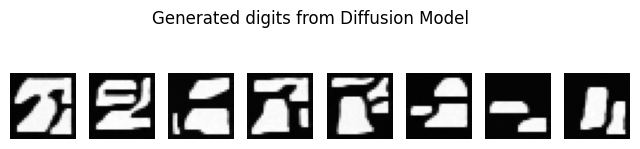

In [13]:
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(samples[i, 0].cpu().numpy(), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated digits from Diffusion Model")
plt.show()
